In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from ebc.sequential.non_iterative import SensitivityBasedIS
from ebc.sequential.iterative_with_convexification import SensitivityBasedFW
from ebc.sequential.iterative_no_convexification import SparseVI, GIGA, IHT
from ebc.gaussian import fisher_norm_under_true_gaussian_posterior, gaussian_multivariate_log_likelihood, gaussian_KL
import multiprocessing as mp
from multiprocessing import get_context


Bad key text.latex.preview in file /opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

In [2]:
from sklearn.decomposition import PCA

def plot_points(points, indices, w):
    pca = PCA(n_components = 2)
    vecs = pca.fit_transform(points)
    plt.scatter(vecs[indices, 0], vecs[indices, 1], 
                  s = w.flatten()[indices] * 50, alpha = 0.5)
    vecs = np.delete(vecs, indices, axis = 0)
    plt.scatter(vecs[:, 0], vecs[:, 1], alpha = 0.5, label = "NOT in coreset")
    plt.title("Points")
    plt.ylabel("PCA2")
    plt.xlabel("PCA1")
    plt.grid()
    plt.legend()
    
def plot_results(fkl, bkl, points, indices, w):
    fig, ax = plt.subplots(1, 3, figsize = (20, 5))
    ax[0].plot(fkl)
    ax[0].set_title("FKL")
    ax[0].set_ylabel("FKL")
    ax[0].set_xlabel("Coreset Size")
    ax[0].grid()
    
    ax[1].plot(fkl)
    ax[1].set_title("BKL")
    ax[1].set_ylabel("BKL")
    ax[1].set_xlabel("Coreset Size")
    ax[1].grid()
    
    pca = PCA(n_components = 2)
    vecs = pca.fit_transform(points)
    ax[2].scatter(vecs[indices, 0], vecs[indices, 1], 
                  s = w.flatten()[indices] * 50, alpha = 0.5)
    vecs = np.delete(vecs, indices, axis = 0)
    ax[2].scatter(vecs[:, 0], vecs[:, 1], alpha = 0.5, label = "NOT in coreset")
    ax[2].set_title("Points")
    ax[2].set_ylabel("PCA2")
    ax[2].set_xlabel("PCA1")
    ax[2].grid()
    ax[2].legend()
    
    #for ind in indices:
    #    ax[2].annotate(round(w.flatten()[ind]), (vecs[ind, 0], vecs[ind, 1]))

In [3]:
def distribute_randomly(x):
    N = x.shape[0]
    
    probs = np.ones(N) / N
    
    # Calculate probabilities for distribution for each data point
    full_inds = []
    chunk_size = N // (mp.cpu_count() - 2)
    
    for i in range(mp.cpu_count() - 2):
        inds = np.random.choice(np.arange(N), chunk_size, replace = False, p = probs)
        probs[inds] = 0
        probs = probs / np.sum(probs)
        full_inds.append(inds.flatten().tolist())

    full_inds.append(np.arange(N)[probs.flatten() != 0].tolist())
    
    return full_inds

In [4]:
def external_parallelization(alg, x, k, norm, na, distributed_indices, likelihood_gram_matrix, y):
    pool = get_context("fork").Pool(mp.cpu_count() - 1)
    
    if likelihood_gram_matrix is None:
        output = [pool.apply(apply_algorithm, args = [alg, 
                                                      x[ind, :],
                                                      k, 
                                                      norm, 
                                                      na,
                                                      None,
                                                      y[ind, :]]) for ind in distributed_indices]
    else:
        output = [pool.apply(apply_algorithm, args = [alg, 
                                                      x[ind, :],
                                                      k, 
                                                      norm, 
                                                      na,
                                                      likelihood_gram_matrix[np.ix_(ind, ind)], y[ind, :]]) for ind in distributed_indices]
    
    
    pool.close()
    w = np.concatenate(output)
    
    return w

In [5]:
def apply_algorithm(alg, 
                    x = None, 
                    k = None,
                    norm = None,
                    na = None,
                    likelihood_gram_matrix = None,
                    y = None):
    inst = alg(x, y)
    w, I = inst.run(k = k, likelihood_gram_matrix = likelihood_gram_matrix, norm = norm, norm_attributes = na)
    return w

In [6]:
coreset_sizes = np.arange(100, 1200, 200)

## 1. Multivariate Gaussian's Mean

In [7]:
def log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return np.diag(gaussian_multivariate_log_likelihood(X.T, mu, sigma)).reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return (-np.linalg.inv(sigma) @ (X.T - mu)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

In [8]:
fkl_s = []
bkl_s = []

fkl_p = []
bkl_p = []

time_p = []
time_s = []

# Generate Data
d = 20
N = 10000

np.random.seed(123)

# Theta as in sparse_vi
theta = np.random.multivariate_normal(mean = np.zeros(d), cov = np.identity(d))

# x as in sparse_vi
x = np.random.multivariate_normal(mean = theta, cov = np.identity(d), size = N)

# Parameters
sigma_0 = np.identity(d)
sigma = np.identity(d)
mu_0 = np.zeros(d).reshape(-1, 1)

# Full Gaussian posterior
sigma_full = np.linalg.inv(np.linalg.inv(sigma_0) + N * np.linalg.inv(sigma))
mu_full =  sigma_full @ (np.linalg.inv(sigma_0) @ mu_0 + np.linalg.inv(sigma) @ np.sum(x, axis = 0).reshape(-1, 1))        

na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 500,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": 500,
      "log_posterior": log_posterior,
      "log_posterior_start_value": np.ones(2 * d)}

for i in coreset_sizes:
    
    print(i)
    
    ## Parallel
    
    start = time.time()
    
    # Step 1: distribute
    full_inds = distribute_randomly(x)
    
    # Step 2: run IS
    w_is = external_parallelization(SensitivityBasedIS, x, i, "2", 
                                 na, full_inds, None)
    
    # Step 3: get smaller dataset
    x_new = x[w_is.flatten() != 0]
    x_new = x_new.copy()
    
    # Step 4: run FW on it
    sbfw = SensitivityBasedFW(x_new)
    w_fw, I_fw = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)
    
    w_is[w_is.flatten() != 0] = w_fw
    w = w_is.copy()
    
    time_p.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
    
    # Sequential
    start = time.time()
    sbfw = SensitivityBasedFW(x)
    w, I = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)
    time_s.append(time.time() - start)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

100
300
500
700
900
1100


In [10]:
fkl_s

[1358.7627025962242,
 1633.4327904517986,
 577.716256956607,
 13.509597260453269,
 941.2470496207682,
 11.92199292874578]

In [11]:
fkl_p

[29.749293769600083,
 17.4297895242882,
 40.36183025414981,
 26.203125717510552,
 62.996259107233065,
 315.3704331276808]

In [12]:
bkl_s

[1371.7113822540384,
 1627.3722687141903,
 580.9005926059805,
 13.563782327181999,
 949.631639061337,
 11.902286016465416]

In [13]:
bkl_p

[327.6386183966622,
 85.88848176011572,
 165.3327959179821,
 97.27732104730782,
 163.33443648659735,
 720.5368321361025]

In [14]:
time_s

[779.8719487190247,
 800.5873231887817,
 815.9593460559845,
 851.1231389045715,
 859.1312372684479,
 872.4340128898621]

In [15]:
time_p

[136.34799909591675,
 154.4262571334839,
 220.8432948589325,
 177.96477794647217,
 290.3898820877075,
 425.7371668815613]

Text(0.5, 1.0, 'Time')

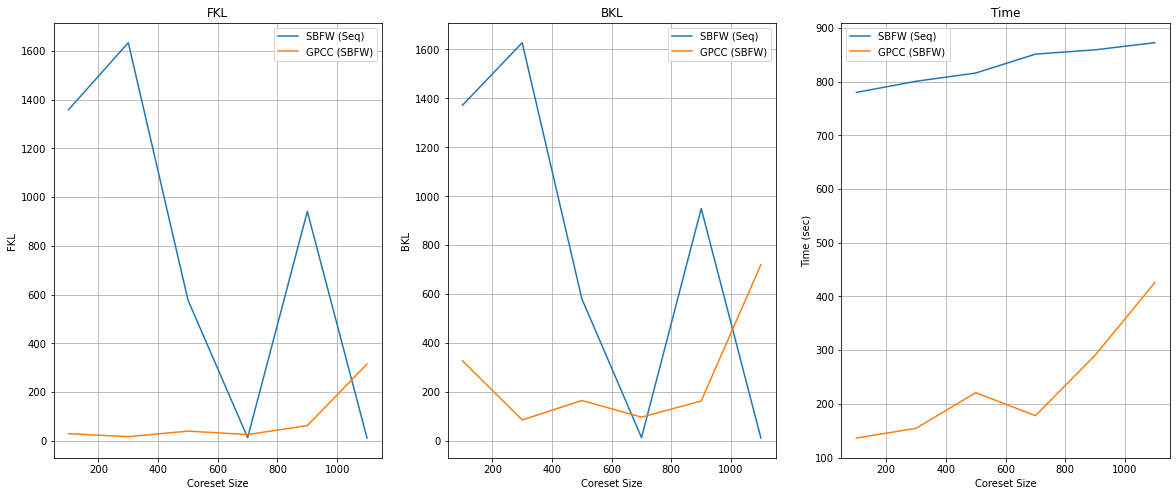

In [16]:
fig, ax = plt.subplots(1, 3, figsize = (20, 8))
ax[0].plot(coreset_sizes, fkl_s, label = 'SBFW (Seq)')
ax[0].plot(coreset_sizes, fkl_p, label = 'GPCC (SBFW)')
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel('FKL')
ax[0].set_xlabel('Coreset Size')
ax[0].set_title('FKL')

ax[1].plot(coreset_sizes, bkl_s, label = 'SBFW (Seq)')
ax[1].plot(coreset_sizes, bkl_p, label = 'GPCC (SBFW)')
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel('BKL')
ax[1].set_xlabel('Coreset Size')
ax[1].set_title('BKL')

ax[2].plot(coreset_sizes, time_s, label = 'SBFW (Seq)')
ax[2].plot(coreset_sizes, time_p, label = 'GPCC (SBFW)')
ax[2].legend()
ax[2].grid()
ax[2].set_ylabel('Time (sec)')
ax[2].set_xlabel('Coreset Size')
ax[2].set_title('Time')

## 3. Gaussian Regression

In [7]:
coreset_sizes = np.arange(50, 301, 50)

In [8]:
def log_likelihood(params, X, y, weights):
    N, d = X.shape
    beta = params.reshape(-1, 1)
    sigma = np.identity(N)
    
    return np.diag(gaussian_multivariate_log_likelihood(y, X @ beta, sigma)).reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    N, d = X.shape
    sigma = 1e-4 * np.identity(N)
    beta = params.reshape(-1, 1)
    
    return (-np.linalg.inv(sigma) @ (y - X @ beta)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

In [9]:
seeds = [123]

for seed in seeds:
    # Generate Data
    d = 20
    N = 1000

    np.random.seed(seed)

    # x as in sparse_vi
    cov = np.identity(d) * 3
    cov[cov == 0] = 1
    x = np.random.multivariate_normal(mean = np.zeros(d), cov = cov, size = N)

    # as in svi
    mu_0 = np.zeros(d).reshape(-1, 1)
    sigma_0 = np.identity(d)
    #beta = np.random.multivariate_normal(mu_0.flatten(), sigma_0).reshape(-1, 1)
    beta = np.random.randint(3, 10, size = d).reshape(-1, 1)

    # y
    sigma = 1
    y = x @ beta + np.random.normal(0, sigma, (N, 1))

    # Full  posterior
    sigma_full = np.linalg.inv(np.linalg.inv(sigma_0) + 1 / sigma ** 2 * x.T @ x)
    mu_full =  sigma_full @ (np.linalg.inv(sigma_0) @ mu_0 + 1 / sigma ** 2 * np.sum(y * x, axis = 0).reshape(-1, 1))        

    fkl_s = []
    bkl_s = []

    fkl_p = []
    bkl_p = []

    time_p = []
    time_s = []

    na = {"log_likelihood": log_likelihood,
          "log_likelihood_start_value": np.ones(d),
          "S": 500,
          "log_likelihood_gradient": grad_log_likelihood,
          "approx": "Laplace",
          "MCMC_subs_size": 500,
          "log_posterior": log_posterior,
          "log_posterior_start_value": np.ones(d)}
    j = 0
    for i in coreset_sizes:
        
        print(i)
    
        ## Parallel

        start = time.time()

        # Step 1: distribute
        full_inds = distribute_randomly(x)

        # Step 2: run IS
        w_is = external_parallelization(SensitivityBasedIS, x, i, "2", 
                                     na, full_inds, None, y)

        # Step 3: get smaller dataset
        x_new = x[w_is.flatten() != 0]
        x_new = x_new.copy()
        y_new = y[w_is.flatten() != 0]
        y_new = y_new.copy()

        # Step 4: run FW on it
        sbfw = SensitivityBasedFW(x_new, y_new)
        w_fw, I_fw = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)

        w_is[w_is.flatten() != 0] = w_fw
        w = w_is.copy()

        time_p.append(time.time() - start)
    
        # Calculate posterior approximation
        sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
        mu_hat = sigma_hat @ (mu_0 + x.T @ w)

        fkl_p.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
        bkl_p.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
        
        # Sequential
        start = time.time()
        sbfw = SensitivityBasedFW(x, y)
        w, I = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)
        time_s.append(time.time() - start)

        # Calculate posterior approximation
        sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
        mu_hat = sigma_hat @ (mu_0 + x.T @ w)

        fkl_s.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
        bkl_s.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

50
100
150
200
250
300


Text(0.5, 1.0, 'Time')

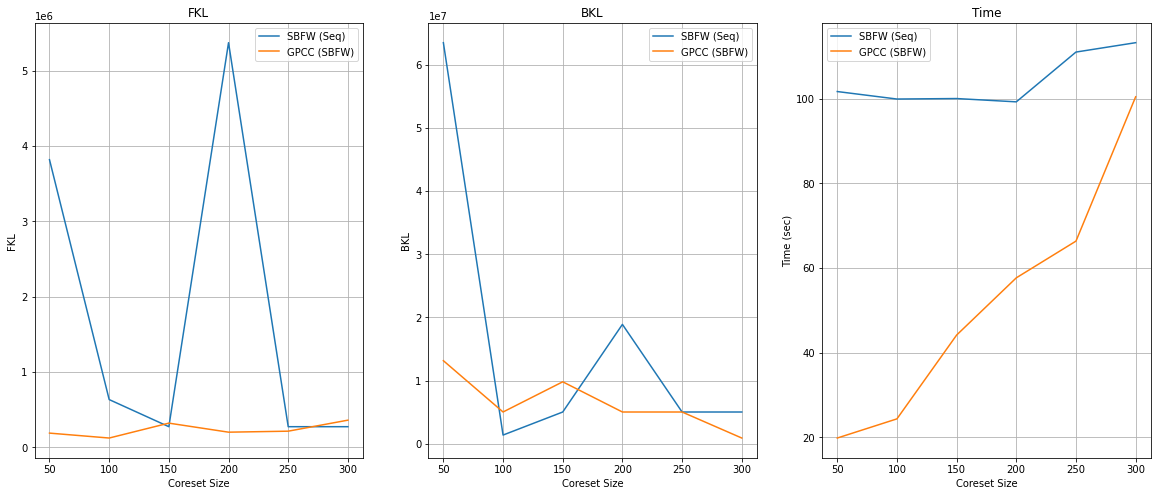

In [13]:
fig, ax = plt.subplots(1, 3, figsize = (20, 8))
ax[0].plot(coreset_sizes, fkl_s, label = 'SBFW (Seq)')
ax[0].plot(coreset_sizes, fkl_p, label = 'GPCC (SBFW)')
ax[0].legend()
ax[0].grid()
ax[0].set_ylabel('FKL')
ax[0].set_xlabel('Coreset Size')
ax[0].set_title('FKL')

ax[1].plot(coreset_sizes, bkl_s, label = 'SBFW (Seq)')
ax[1].plot(coreset_sizes, bkl_p, label = 'GPCC (SBFW)')
ax[1].legend()
ax[1].grid()
ax[1].set_ylabel('BKL')
ax[1].set_xlabel('Coreset Size')
ax[1].set_title('BKL')

ax[2].plot(coreset_sizes, time_s, label = 'SBFW (Seq)')
ax[2].plot(coreset_sizes, time_p, label = 'GPCC (SBFW)')
ax[2].legend()
ax[2].grid()
ax[2].set_ylabel('Time (sec)')
ax[2].set_xlabel('Coreset Size')
ax[2].set_title('Time')

## 4. Regression on Real Dataset

In [32]:
from sklearn.datasets import load_boston
X = load_boston()['data']
y = load_boston()['target']
y.shape

(506,)

In [21]:
def log_likelihood(params, X, y, weights):
    N, d = X.shape
    beta = params.reshape(-1, 1)
    sigma = np.identity(N)
    
    return np.diag(gaussian_multivariate_log_likelihood(y, X @ beta, sigma)).reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    N, d = X.shape
    sigma = 1e-4 * np.identity(N)
    beta = params.reshape(-1, 1)
    
    return (-np.linalg.inv(sigma) @ (y - X @ beta)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

In [22]:
from sklearn.datasets import load_boston
X = load_boston()['data']
y = load_boston()['target']

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

lr = LinearRegression()
ref = lr.fit(X, y).predict(X)

In [25]:
seeds = [123, 1234, 12345, 123456, 1234567]

maes = []

for seed in seeds:
    # Generate Data
    N, d = X.shape

    np.random.seed(seed)     

    from ebc.approximations import random_kitchen_sinks
    v = random_kitchen_sinks(X, y, 1, "Laplace", log_likelihood, 
                         np.ones(d), 1000, norm = "2", MCMC_subs_size = 500)

    likelihood_gram_matrix = v @ v.T

    mae = np.zeros((10, 5))

    na = {"log_likelihood": log_likelihood,
          "log_likelihood_start_value": np.ones(d),
          "S": 500,
          "log_likelihood_gradient": grad_log_likelihood,
          "approx": "MCMC",
          "MCMC_subs_size": 500,
          "log_posterior": log_posterior,
          "log_posterior_start_value": np.ones(d)}
    j = 0
    for i in range(1, 100, 10):
        print(i)
        sbis = SensitivityBasedIS(X, y)
        sbfw = SensitivityBasedFW(X, y)
        giga = GIGA(X, y)
        svi = SparseVI(X, y)
        iht = IHT(X, y)

        w1, I1 = sbis.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
        w2, I2 = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
        w3, I3 = giga.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
        w4, I4 = svi.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, 
                         norm_attributes = na, T = 400, gamma_func = lambda x : 0.01 / x)
        w5, I5 = iht.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
        
        lr = LinearRegression()
        pred1 = lr.fit(X * w1, y).predict(X)
        pred2 = lr.fit(X * w2, y).predict(X)
        pred3 = lr.fit(X * w3, y).predict(X)
        pred4 = lr.fit(X * w4, y).predict(X)
        pred5 = lr.fit(X * w5, y).predict(X)
        
        mae[j, 0] = mean_absolute_error(ref, pred1)
        mae[j, 1] = mean_absolute_error(ref, pred2)
        mae[j, 2] = mean_absolute_error(ref, pred3)
        mae[j, 3] = mean_absolute_error(ref, pred4)
        mae[j, 4] = mean_absolute_error(ref, pred5)

        j += 1
        
    maes.append(mae)

1
11
21
31
41
51
61
71
81
91
1
11
21
31
41
51
61
71
81
91
1
11
21
31
41
51
61
71
81
91
1
11
21
31
41
51
61
71
81
91
1
11
21
31
41
51
61
71
81
91


In [26]:
maemeds = np.zeros((10, 5))
maestds = np.zeros((10, 5))

for k in range(5):
    for j in range(10):
        agr = []
        for i in range(2):
            agr.append(maes[i][j][k])
        maemeds[j, k] = np.median(agr)
        maestds[j, k] = np.std(agr)

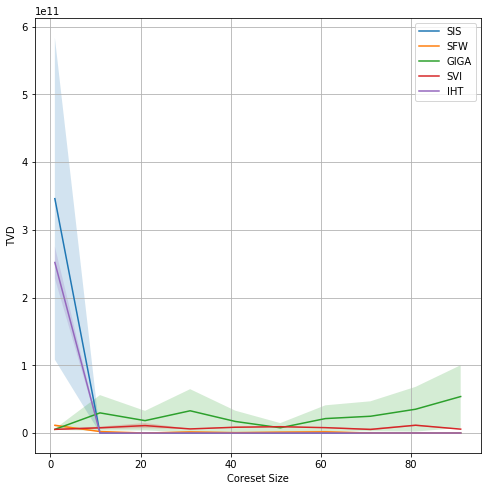

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.plot(coreset_size, maemeds[:, 0], label = 'SIS')
ax.plot(coreset_size, maemeds[:, 1], label = 'SFW')
ax.plot(coreset_size, maemeds[:, 2], label = 'GIGA')
ax.plot(coreset_size, maemeds[:, 3], label = 'SVI')
ax.plot(coreset_size, maemeds[:, 4], label = 'IHT')
ax.fill_between(coreset_size, maemeds[:, 0] - maestds[:, 0], maemeds[:, 0] + maestds[:, 0], alpha=0.2)
ax.fill_between(coreset_size, maemeds[:, 1] - maestds[:, 1], maemeds[:, 1] + maestds[:, 1], alpha=0.2)
ax.fill_between(coreset_size, maemeds[:, 2] - maestds[:, 2], maemeds[:, 2] + maestds[:, 2], alpha=0.2)
ax.fill_between(coreset_size, maemeds[:, 3] - maestds[:, 3], maemeds[:, 3] + maestds[:, 3], alpha=0.2)
ax.fill_between(coreset_size, maemeds[:, 4] - maestds[:, 4], maemeds[:, 4] + maestds[:, 4], alpha=0.2)
ax.legend()
ax.set_xlabel("Coreset Size")
ax.set_ylabel("TVD")
ax.grid()

## 5. Images

In [35]:
from sklearn.datasets import load_digits
X = load_digits()['data']
y_labels = load_digits()['target']
y_labels.shape

(1797,)

In [33]:
def log_likelihood(params, X, y, weights):
    N, d = X.shape
    c = y.shape[1]
    w = params.reshape(d, c)
    preds = X @ w
    probs = np.exp(preds - np.max(preds, axis = 1, keepdims = True))
    probs = probs / np.sum(probs, axis = 1, keepdims = True)
    probs[probs == 0] = 1e-10
    ll = np.sum(y * np.log(probs), axis = 1)
    return ll.reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return (-np.linalg.inv(sigma) @ (X.T - mu)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

In [34]:
# https://github.com/izmailovpavel/neurips_bdl_starter_kit/blob/main/metrics.py
import scipy

def total_variation_distance(reference: np.array, predictions: np.array):
    """Returns total variation distance."""
    return np.abs(predictions - reference).sum(axis=-1).mean() / 2.


def w2_distance(reference: np.array, predictions: np.array):
    """Returns W-2 distance """
    assert predictions.shape[0] == reference.shape[0], "wrong predictions shape"
    return -np.mean([scipy.stats.wasserstein_distance(pred, ref) for 
                   pred, ref in zip(predictions, reference)])

In [35]:
from sklearn.datasets import load_digits
X = load_digits()['data']
y_labels = load_digits()['target']

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
ref = lr.fit(X, y_labels).predict(X)

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y = lb.fit_transform(y_labels)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
seeds = [123, 1234, 12345, 123456, 1234567]

tvs = []
wass2s = []

for seed in seeds:

    np.random.seed(seed)
    
    tv = np.zeros((10, 5))
    wass2 = np.zeros((10, 5))

    na = {"log_likelihood": log_likelihood,
          "log_likelihood_start_value": np.zeros(X.shape[1] * y.shape[1]).reshape(-1, 1),
          "S": 500,
          "log_likelihood_gradient": grad_log_likelihood,
          "approx": "MCMC",
          "MCMC_subs_size": 1000,
          "log_posterior": log_posterior,
          "log_posterior_start_value": np.zeros(X.shape[1] * y.shape[1]).reshape(-1, 1)}
    
    
    from ebc.approximations import random_kitchen_sinks
    v = random_kitchen_sinks(X, y, 1, "Laplace", log_likelihood, 
                             np.ones(X.shape[1] * y.shape[1]).reshape(-1, 1), 
                             1000, norm = "2", MCMC_subs_size = 500)

    likelihood_gram_matrix = v @ v.T
    
    j = 0
    for i in range(1, 100, 10):
        
        sbis = SensitivityBasedIS(X, y)
        sbfw = SensitivityBasedFW(X, y)
        giga = GIGA(X, y)
        svi = SparseVI(X, y)
        iht = IHT(X, y)
        w1, I1 = sbis.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
        w2, I2 = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
        w3, I3 = giga.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
        w4, I4 = svi.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, 
                         norm_attributes = na, T = 400, gamma_func = lambda x : 1e-4 / x)
        w5, I5 = iht.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
        
        lr = LogisticRegression()
        pred1 = lr.fit(X * w1, y_labels).predict(X)
        pred2 = lr.fit(X * w2, y_labels).predict(X)
        pred3 = lr.fit(X * w3, y_labels).predict(X)
        pred4 = lr.fit(X * w4, y_labels).predict(X)
        pred5 = lr.fit(X * w5, y_labels).predict(X)
        
        
        tv[j, 0] = total_variation_distance(ref, pred1)
        try:
            wass2[j, 0] = w2_distance(ref, pred1)
        except:
            wass2[j, 0] = np.nan
        
        tv[j, 1] = total_variation_distance(ref, pred2)
        try:
            wass2[j, 1] = w2_distance(ref, pred2)
        except:
            wass2[j, 1] = np.nan
        
        tv[j, 2] = total_variation_distance(ref, pred3)
        try:
            wass2[j, 2] = w2_distance(ref, pred3)
        except:
            wass2[j, 2] = np.nan
        
        tv[j, 3] = total_variation_distance(ref, pred4)
        try:
            wass2[j, 3] = w2_distance(ref, pred4)
        except:
            wass2[j, 3] = np.nan
        
        tv[j, 4] = total_variation_distance(ref, pred5)
        try:
            wass2[j, 4] = w2_distance(ref, pred5)
        except:
            wass2[j, 4] = np.nan

        j += 1
        
    tvs.append(tv)
    wass2s.append(wass2)

/Users/vladimiromelyusik/efficient_bayesian_coresets/ebc/approximations.py:72: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mu_approx, sigma_approx, S) # S x (#mu + #sigma)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [37]:
tvsmeds = np.zeros((10, 5))
tvsstds = np.zeros((10, 5))

for k in range(5):
    for j in range(10):
        agr = []
        
        for i in range(5):
            agr.append(tvs[i][j][k])
        tvsmeds[j, k] = np.median(agr)
        tvsstds[j, k] = np.std(agr)

In [39]:
coreset_size = np.arange(1, 100, 10)

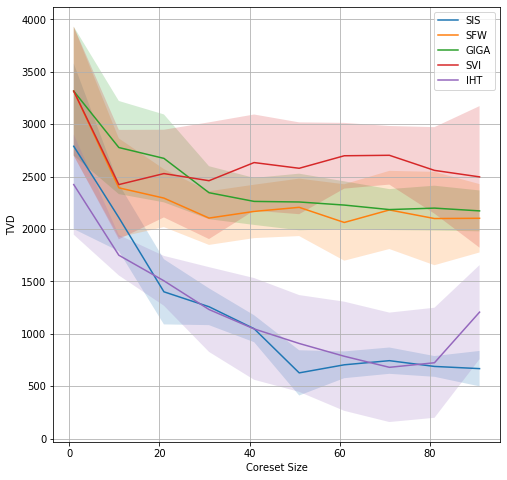

In [47]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.plot(coreset_size, tvsmeds[:, 0], label = 'SIS')
ax.plot(coreset_size, tvsmeds[:, 1], label = 'SFW')
ax.plot(coreset_size, tvsmeds[:, 2], label = 'GIGA')
ax.plot(coreset_size, tvsmeds[:, 3], label = 'SVI')
ax.plot(coreset_size, tvsmeds[:, 4], label = 'IHT')
ax.fill_between(coreset_size, tvsmeds[:, 0] - tvsstds[:, 0], tvsmeds[:, 0] + tvsstds[:, 0], alpha=0.2)
ax.fill_between(coreset_size, tvsmeds[:, 1] - tvsstds[:, 1], tvsmeds[:, 1] + tvsstds[:, 1], alpha=0.2)
ax.fill_between(coreset_size, tvsmeds[:, 2] - tvsstds[:, 2], tvsmeds[:, 2] + tvsstds[:, 2], alpha=0.2)
ax.fill_between(coreset_size, tvsmeds[:, 3] - tvsstds[:, 3], tvsmeds[:, 3] + tvsstds[:, 3], alpha=0.2)
ax.fill_between(coreset_size, tvsmeds[:, 4] - tvsstds[:, 4], tvsmeds[:, 4] + tvsstds[:, 4], alpha=0.2)
ax.legend()
ax.set_xlabel("Coreset Size")
ax.set_ylabel("TVD")
ax.grid()